## Predicting Crashes in Financial Markets - RNN LSTM
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: RNN LSTM (stateless)
- Response variable: Crash within 1, 3 and 6 months (0: no, 1: yes)
- Crash definition: Drawdown in 99.5% quantile
- v3:volatility as addl feature

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

Using TensorFlow backend.


In [ ]:
import importlib
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
import prepare_data_7
importlib.reload(prepare_data_7)

In [2]:
# -------------------- data preparation -------------------- #
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data_7 import DataLoader
os.chdir('/home/roman/Documents/Projects/Bubbles/data')

datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv', '^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
data = DataLoader(datasets_original, dataset_names)

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344] # <-- Jacobsson
#crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264] # <-- Sornette
df_combined, drawdowns, crashes = data.get_df_combined(crash_thresholds)

months = [1, 3, 6]       # <-- predict if crash n months ahead
#select_features = False  # <-- if True: 8 time windows for mean price change and vol year
sequence = 10             # <-- number of days lookback as input(only if select_features=False)
additional_feat = True  # <-- if True: add mean price change and volatility for 4 time widnows over 252 days
batch_size = 50          # <-- batch size needs to be specified to satisfy stateful=True
#vol = False             # <-- if True: include 10 day volatility for each day in sequence (only in prepare_data_2)
dfs_x1, dfs_x2, dfs_y = data.get_df_xy(months=months, sequence=sequence, df_combined=df_combined, \
                            crashes=crashes, batch_size=batch_size, additional_feat=additional_feat)

In [5]:
# -------------------- RNN LSTM model -------------------- #
model_name = 'RNN LSTM'
neurons = 50
dropout = 0.2
optimizer = 'adam'
loss = 'mse'   # 'binary_crossentropy'
activation = 'linear'
inp_dim = 2   # <-- 1 if price change only, 2 if volatility as well
inp_tsteps = sequence + 4 * additional_feat
def rnn_lstm(inp_tsteps, inp_dim, neurons, dropout):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inp_tsteps, inp_dim), return_sequences=True))
    model.add(Dropout(dropout))
    #model.add(LSTM(neurons, return_sequences=True))
    model.add(LSTM(neurons, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation=activation))   # 'sigmoid'
    return model
model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
model.compile(loss=loss, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 14, 50)            10600     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 30,953
Trainable params: 30,953
Non-trainable params: 0
_________________________________________________________________


In [6]:
# -------------------- Train and test RNN LSTM model -------------------- #
epochs = 20
os.chdir('/home/roman/Documents/Projects/Bubbles/models/model_weights/')
#filepath = 'weights.{epoch:02d}.hdf5'
#checkpoint = ModelCheckpoint(filepath)
for test_data in dataset_names:
    model = rnn_lstm(neurons=neurons, inp_tsteps=inp_tsteps, inp_dim=inp_dim, dropout=dropout)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    np_x1_train, np_x2_train, np_y_train, _, _, _ = data.get_train_test(dfs_x1, dfs_x2, dfs_y, 
            dataset_names, test_data=test_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)
    #x_train = np_train[:, 0:-len(months)]             
    #np_x1_train = np.expand_dims(np_x1_train, axis=2)
    #np_x2_train = np.expand_dims(np_x2_train, axis=2)
    #np_y_train = np_y_train.astype(int)
    print('Train ' + str(model_name) + ' - test data: ' + str(test_data))
    for e in range(epochs):
        model.fit(np_x_train, np_y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=True)
        if (e + 1) % 5 == 0:
            model.save_weights('stateless_s10_2d_f_d_{0}_{1}.hdf5'.format(test_data, e + 1))

Train RNN LSTM - test data: S&P 500
Epoch 1/1
42900/42900 [==============================] - 55s 1ms/step - loss: 0.0428 - acc: 0.0436
Epoch 1/1
42900/42900 [==============================] - 53s 1ms/step - loss: 0.0425 - acc: 0.0412
Epoch 1/1
42900/42900 [==============================] - 58s 1ms/step - loss: 0.0423 - acc: 0.0420
Epoch 1/1
42900/42900 [==============================] - 66s 2ms/step - loss: 0.0420 - acc: 0.0440
Epoch 1/1
42900/42900 [==============================] - 55s 1ms/step - loss: 0.0419 - acc: 0.0480
Epoch 1/1
42900/42900 [==============================] - 54s 1ms/step - loss: 0.0416 - acc: 0.0524
Epoch 1/1
42900/42900 [==============================] - 52s 1ms/step - loss: 0.0412 - acc: 0.0546
Epoch 1/1
42900/42900 [==============================] - 56s 1ms/step - loss: 0.0408 - acc: 0.0558
Epoch 1/1
42900/42900 [==============================] - 53s 1ms/step - loss: 0.0400 - acc: 0.0627
Epoch 1/1
42900/42900 [==============================] - 53s 1ms/step - l

In [7]:
# -------------------- Load weights and predict results -------------------- #
epoch = 10 # <-- change to load model weights from previous epochs
y_train_all = []
y_test_all = []
y_pred_tr_all = []
y_pred_t_all = []
for test_data in dataset_names:
    np_x1_train, np_x2_train, np_y_train, np_x1_test, np_x2_test, np_y_test = \
        data.get_train_test(dfs_x1, dfs_x2, dfs_y, dataset_names, test_data=test_data)
    np_x_train = np.concatenate([np_x1_train, np_x2_train], axis=2)        #####################
    np_x_test = np.concatenate([np_x1_test, np_x2_test], axis=2)      #####################
    y_train_all.append(np_y_train)
    y_test_all.append(np_y_test)
    model.load_weights('stateless_s10_2d_f_d_{0}_{1}.hdf5'.format(test_data, epoch))
    y_pred_tr = model.predict(np_x_train, batch_size=batch_size) 
    y_pred_tr_all.append(y_pred_tr)
    y_pred_t = model.predict(np_x_test, batch_size=batch_size)
    y_pred_t_all.append(y_pred_t)

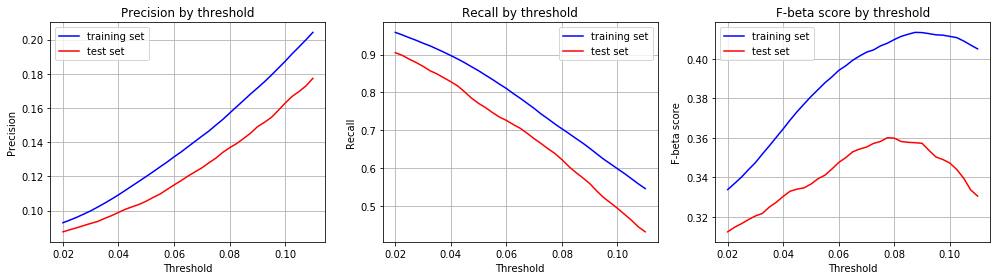

In [18]:
# -------------------- Find best threshold -------------------- #
beta = 2
month_prediction = 6   # <-- predict crash in 1, 3 or 6 months
i = [i for i, mo in enumerate(months) if mo == month_prediction][0]
precision_tr_all, recall_tr_all, accuracy_tr_all = [], [], []
precision_t_all, recall_t_all, accuracy_t_all = [], [], [] 
fbeta_tr_all, fbeta_t_all = [], []
thresholds = [0.02, 0.0225, 0.025, 0.0275, 0.03, 0.0325, 0.035, 0.0375, 0.040, 0.0425, \
              0.045, 0.0475, 0.05, 0.0525, 0.055, 0.0575, 0.06, 0.0625, 0.065, 0.0675, \
              0.07, 0.0725, 0.075, 0.0775, 0.08, 0.0825, 0.085, 0.0875, 0.09, 0.0925, \
              0.095,  0.0975, 0.1, 0.1025, 0.105, 0.1075, 0.11]
for threshold in thresholds:
    precision_tr, recall_tr, accuracy_tr = [], [], []
    precision_t, recall_t, accuracy_t = [], [], []
    y_pred_t_bin_all, y_pred_tr_bin_all = [], []
    score_fbeta_tr, score_fbeta_t = [], []
    for y_train, y_test, y_pred_tr, y_pred_t in zip(y_train_all, y_test_all, \
                                                    y_pred_tr_all, y_pred_t_all):
        y_train = y_train[:, i]  
        y_pred_tr = y_pred_tr[:, i]
        y_test = y_test[:, i]
        y_pred_t = y_pred_t[:, i]
        y_pred_tr_bin = y_pred_tr > threshold
        y_pred_tr_bin = y_pred_tr_bin.astype(int)
        y_pred_tr_bin_all.append(y_pred_tr_bin)
        precision_tr.append(metrics.precision_score(y_train, y_pred_tr_bin))
        recall_tr.append(metrics.recall_score(y_train, y_pred_tr_bin))
        accuracy_tr.append(metrics.accuracy_score(y_train, y_pred_tr_bin))
        score_fbeta_tr.append(metrics.fbeta_score(y_train, y_pred_tr_bin, beta=beta))
        y_pred_t_bin = y_pred_t > threshold
        y_pred_t_bin = y_pred_t_bin.astype(int)
        y_pred_t_bin_all.append(y_pred_t_bin)
        precision_t.append(metrics.precision_score(y_test, y_pred_t_bin))
        recall_t.append(metrics.recall_score(y_test, y_pred_t_bin))
        accuracy_t.append(metrics.accuracy_score(y_test, y_pred_t_bin))
        score_fbeta_t.append(metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta))
    precision_tr_all.append(np.mean(precision_tr)) 
    precision_t_all.append(np.mean(precision_t)) 
    recall_tr_all.append(np.mean(recall_tr)) 
    recall_t_all.append(np.mean(recall_t))
    accuracy_tr_all.append(np.mean(accuracy_tr)) 
    accuracy_t_all.append(np.mean(accuracy_t))
    fbeta_tr_all.append(np.mean(score_fbeta_tr))
    fbeta_t_all.append(np.mean(score_fbeta_t))
rcParams['figure.figsize'] = 14, 4
plt.subplot(1,3,1)
plt.plot(thresholds, precision_tr_all, color='blue')
plt.plot(thresholds, precision_t_all, color='red')
plt.title('Precision by threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.legend(['training set', 'test set'])
plt.grid()
plt.subplot(1,3,2)
plt.plot(thresholds, recall_tr_all, color='blue')
plt.plot(thresholds, recall_t_all, color='red')
plt.title('Recall by threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.legend(['training set', 'test set'])
plt.grid()
plt.subplot(1,3,3)
plt.plot(thresholds, fbeta_tr_all, color='blue')
plt.plot(thresholds, fbeta_t_all, color='red')
plt.title('F-beta score by threshold')
plt.xlabel('Threshold')
plt.ylabel('F-beta score')
plt.legend(['training set', 'test set'])
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
# -------------------- Evaluate results -------------------- #
threshold = 0.085
precision_tr, recall_tr, accuracy_tr = [], [], []
precision_t, recall_t, accuracy_t = [], [], []
y_pred_t_bin_all, y_pred_tr_bin_all = [], []
score_fbeta_tr, score_fbeta_t = [], []
for y_train, y_test, y_pred_tr, y_pred_t in zip(y_train_all, y_test_all, \
                                                y_pred_tr_all, y_pred_t_all):
    y_train = y_train[:, i]
    y_pred_tr = y_pred_tr[:, i]
    y_test = y_test[:, i]
    y_pred_t = y_pred_t[:, i]
    y_pred_tr_bin = y_pred_tr > threshold
    y_pred_tr_bin = y_pred_tr_bin.astype(int)
    y_pred_tr_bin_all.append(y_pred_tr_bin)
    precision_tr.append(metrics.precision_score(y_train, y_pred_tr_bin))
    recall_tr.append(metrics.recall_score(y_train, y_pred_tr_bin))
    accuracy_tr.append(metrics.accuracy_score(y_train, y_pred_tr_bin))
    score_fbeta_tr.append(metrics.fbeta_score(y_train, y_pred_tr_bin, beta=beta))
    y_pred_t_bin = y_pred_t > threshold
    y_pred_t_bin = y_pred_t_bin.astype(int)
    y_pred_t_bin_all.append(y_pred_t_bin)
    precision_t.append(metrics.precision_score(y_test, y_pred_t_bin))
    recall_t.append(metrics.recall_score(y_test, y_pred_t_bin))
    accuracy_t.append(metrics.accuracy_score(y_test, y_pred_t_bin))
    score_fbeta_t.append(metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta))

y_tr_pos = [np.mean(y) for y in y_train_all]
y_tr_pred_pos = [np.mean(y_pred) for y_pred in y_pred_tr_bin_all]
y_t_pos = [np.mean(y) for y in y_test_all]
y_t_pred_pos = [np.mean(y_pred) for y_pred in y_pred_t_bin_all]
d = {'positive actual tr': np.round(y_tr_pos, 2), \
     'positive pred tr': np.round(y_tr_pred_pos, 2), \
     'precision tr': np.round(precision_tr,2), \
     'recall tr': np.round(recall_tr,2), 'accuracy_tr': np.round(accuracy_tr,2), \
     'score_fbeta tr': np.round(score_fbeta_tr,2), \
     'positive actual t': np.round(y_t_pos, 2), \
     'positive pred t': np.round(y_t_pred_pos, 2), \
     'precision t': np.round(precision_t,2), \
     'recall t': np.round(recall_t,2), 'accuracy_t': np.round(accuracy_t,2), \
     'score fbeta t': np.round(score_fbeta_t,2)}
results = pd.DataFrame.from_dict(d, orient='index')
results.columns = dataset_names
print('Results - ' + model_name + ':')
print('\n')
print('Predict crash in:         ' + str(months[i]) + ' months')
print('Number of epochs:         ' + str(epochs))
print('Sequence length:          ' + str(sequence))
print('Number of neurons/layer:  ' + str(neurons))
print('Batch size:               ' + str(batch_size))
print('Optimizer:                ' + str(optimizer))
print('Loss function:            ' + str(loss))
print('\n')
print('Results for each train/test split:')
print(results)
print('\n')

# calculate precision, recall, accuracy for comparable random model
sum_tr = 0
sum_t = 0
pos_tr = 0
pos_t = 0
sum_tr_pred = 0
sum_t_pred = 0
pos_tr_pred = 0
pos_t_pred = 0
for y_tr, y_t, y_tr_pr, y_t_pr in zip(y_train_all, y_test_all, y_pred_tr_bin_all, \
                y_pred_t_bin_all):
    sum_tr += len(y_tr[:, i])
    pos_tr += sum(y_tr[:, i])
    sum_t += len(y_t[:, i])
    pos_t += sum(y_t[:, i])
    sum_tr_pred += y_tr_pr.shape[0]
    sum_t_pred += y_t_pr.shape[0]
    pos_tr_pred += sum(y_tr_pr)
    pos_t_pred += sum(y_t_pr)
y_train_pos_actual = pos_tr / sum_tr
y_train_pos_pred = pos_tr_pred / sum_tr_pred
rnd_TP = y_train_pos_pred * y_train_pos_actual
rnd_FP = y_train_pos_pred * (1 - y_train_pos_actual)
rnd_TN = (1 - y_train_pos_pred) * (1 - y_train_pos_actual)
rnd_FN = (1 - y_train_pos_pred) * y_train_pos_actual
rnd_pr_tr = rnd_TP / (rnd_TP + rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP + rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
y_test_pos_actual = pos_t / sum_t
y_test_pos_pred = pos_t_pred / sum_t_pred
rnd_TP = y_test_pos_pred * y_test_pos_actual
rnd_FP = y_test_pos_pred * (1 - y_test_pos_actual)
rnd_TN = (1 - y_test_pos_pred) * (1 - y_test_pos_actual)
rnd_FN = (1 - y_test_pos_pred) * y_test_pos_actual
rnd_pr_t = rnd_TP / (rnd_TP + rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP + rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

print('Results average over all train/test splits:')
print('Number of features: ' + str(sequence) + '; number of rows: ' \
      + str(sum_tr + sum_t))
print('Positive train cases actual:        '+ str(round(y_train_pos_actual, 2)))
print('Positive train cases predicted:     '+ str(round(y_train_pos_pred, 2)))
print('Avg precision train (model/random): '+ str(round(np.mean(precision_tr), 2)) +' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(np.mean(recall_tr), 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(np.mean(accuracy_tr), 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train fbeta:                  '+ str(round(np.mean(score_fbeta_tr), 2)))
print('Positive test cases actual:         '+ str(round(y_test_pos_actual, 2)))
print('Positive test cases predicted:      '+ str(round(y_test_pos_pred, 2)))
print('Avg precision test (model/random):  '+ str(round(np.mean(precision_t), 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(np.mean(recall_t), 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(np.mean(accuracy_t), 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test fbeta:                   '+ str(round(np.mean(score_fbeta_t), 2)))

Results - RNN LSTM:


Predict crash in:         6 months
Number of epochs:         10
Sequence length:          10
Number of neurons/layer:  50
Batch size:               50
Optimizer:                adam
Loss function:            mse


Results for each train/test split:
                    S&P 500  N225   SSE   HSI  BSESN   SMI  BVSP
positive actual tr     0.05  0.04  0.05  0.05   0.05  0.04  0.05
positive pred tr       0.41  0.28  0.31  0.33   0.22  0.41  0.39
precision tr           0.14  0.19  0.16  0.17   0.20  0.14  0.14
recall tr              0.71  0.70  0.63  0.69   0.55  0.76  0.70
accuracy_tr            0.62  0.75  0.71  0.70   0.79  0.63  0.64
score_fbeta tr         0.39  0.46  0.40  0.43   0.41  0.40  0.39
positive actual t      0.04  0.05  0.04  0.04   0.04  0.06  0.05
positive pred t        0.42  0.36  0.27  0.30   0.23  0.41  0.31
precision t            0.13  0.09  0.18  0.09   0.20  0.14  0.16
recall t               0.74  0.38  0.82  0.41   0.60  0.55  0.63
accuracy_t    

In [ ]:
# -------------------- Plot results -------------------- #
test_data = 'S&P 500'
m = [i for i, mo in enumerate(months) if mo == month_prediction][0]
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i][:, m], y_test_all[i][:, m])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1984-01-01', '%Y-%m-%d'), datetime.strptime('1994-01-01', '%Y-%m-%d'), \
           datetime.strptime('2007-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1991-01-01', '%Y-%m-%d'), \
           datetime.strptime('2002-01-01', '%Y-%m-%d'), datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

# test_data = 'N225'
# i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
# dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
#             y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
# df = dfs_predict[i]
# c = crashes[i]
# t_start = [datetime.strptime('1984-01-01', '%Y-%m-%d'), datetime.strptime('2005-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2013-01-01', '%Y-%m-%d')]
# t_end = [datetime.strptime('1992-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2012-01-01', '%Y-%m-%d'), datetime.strptime('2017-01-01', '%Y-%m-%d')]
# rcParams['figure.figsize'] = 10, 6
# for t1, t2 in zip(t_start, t_end):
#     gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
#     plt.subplot(gs[0])
#     y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
#     y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
#     crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
#     crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
#     plt.plot(df_norm[t1:t2], color='blue') 
#     plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
#               + str(t2.year))
#     plt.legend(['price', 'downturn / crash'])
#     plt.xticks([])
#     plt.grid()     
#     plt.subplot(gs[1])
#     plt.plot(df.loc[t1:t2, 'vol'])
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['Volatility'])
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.xticks([])
#     plt.subplot(gs[2])
#     plt.plot(df['y'][t1:t2], color='black')
#     plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['crash within 6m', 'crash predictor'])
#     plt.ylim(0, 1.1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()      

# test_data = 'SSE'
# i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
# dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
#             y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
# df = dfs_predict[i]
# c = crashes[i]
# t_start = [df.index[0], datetime.strptime('2004-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2010-01-01', '%Y-%m-%d')]
# t_end = [datetime.strptime('2002-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2010-01-01', '%Y-%m-%d'), df.index[-1]]
# rcParams['figure.figsize'] = 10, 6
# for t1, t2 in zip(t_start, t_end):
#     gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
#     plt.subplot(gs[0])
#     y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
#     y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
#     crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
#     crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
#     plt.plot(df_norm[t1:t2], color='blue') 
#     plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
#               + str(t2.year))
#     plt.legend(['price', 'downturn / crash'])
#     plt.xticks([])
#     plt.grid()     
#     plt.subplot(gs[1])
#     plt.plot(df.loc[t1:t2, 'vol'])
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['Volatility'])
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.xticks([])
#     plt.subplot(gs[2])
#     plt.plot(df['y'][t1:t2], color='black')
#     plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['crash within 6m', 'crash predictor'])
#     plt.ylim(0, 1.1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()  
    
# test_data = 'HSI'
# i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
# dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
#             y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
# df = dfs_predict[i]
# c = crashes[i]
# t_start = [df.index[0], datetime.strptime('1995-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2005-01-01', '%Y-%m-%d')]
# t_end = [datetime.strptime('1990-01-01', '%Y-%m-%d'), \
#            datetime.strptime('1999-01-01', '%Y-%m-%d'), datetime.strptime('2010-01-01', '%Y-%m-%d')]
# rcParams['figure.figsize'] = 10, 6
# for t1, t2 in zip(t_start, t_end):
#     gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
#     plt.subplot(gs[0])
#     y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
#     y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
#     crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
#     crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
#     plt.plot(df_norm[t1:t2], color='blue') 
#     plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
#               + str(t2.year))
#     plt.legend(['price', 'downturn / crash'])
#     plt.xticks([])
#     plt.grid()     
#     plt.subplot(gs[1])
#     plt.plot(df.loc[t1:t2, 'vol'])
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['Volatility'])
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.xticks([])
#     plt.subplot(gs[2])
#     plt.plot(df['y'][t1:t2], color='black')
#     plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['crash within 6m', 'crash predictor'])
#     plt.ylim(0, 1.1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()  
    
# test_data = 'BSESN'
# i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
# dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
#             y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
# df = dfs_predict[i]
# c = crashes[i]
# t_start = [datetime.strptime('1995-01-01', '%Y-%m-%d'), datetime.strptime('2005-01-01', '%Y-%m-%d')]
# t_end = [datetime.strptime('2003-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2010-01-01', '%Y-%m-%d')]
# rcParams['figure.figsize'] = 10, 6
# for t1, t2 in zip(t_start, t_end):
#     gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
#     plt.subplot(gs[0])
#     y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
#     y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
#     crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
#     crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
#     plt.plot(df_norm[t1:t2], color='blue') 
#     plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
#               + str(t2.year))
#     plt.legend(['price', 'downturn / crash'])
#     plt.xticks([])
#     plt.grid()     
#     plt.subplot(gs[1])
#     plt.plot(df.loc[t1:t2, 'vol'])
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['Volatility'])
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.xticks([])
#     plt.subplot(gs[2])
#     plt.plot(df['y'][t1:t2], color='black')
#     plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['crash within 6m', 'crash predictor'])
#     plt.ylim(0, 1.1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()  

# test_data = 'SMI'
# i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
# dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
#             y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
# df = dfs_predict[i]
# c = crashes[i]
# t_start = [datetime.strptime('1994-01-01', '%Y-%m-%d'), datetime.strptime('2000-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2010-01-01', '%Y-%m-%d')]
# t_end = [datetime.strptime('2000-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2006-01-01', '%Y-%m-%d'), datetime.strptime('2016-01-01', '%Y-%m-%d')]
# rcParams['figure.figsize'] = 10, 6
# for t1, t2 in zip(t_start, t_end):
#     gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
#     plt.subplot(gs[0])
#     y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
#     y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
#     crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
#     crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
#     plt.plot(df_norm[t1:t2], color='blue') 
#     plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
#               + str(t2.year))
#     plt.legend(['price', 'downturn / crash'])
#     plt.xticks([])
#     plt.grid()     
#     plt.subplot(gs[1])
#     plt.plot(df.loc[t1:t2, 'vol'])
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['Volatility'])
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.xticks([])
#     plt.subplot(gs[2])
#     plt.plot(df['y'][t1:t2], color='black')
#     plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['crash within 6m', 'crash predictor'])
#     plt.ylim(0, 1.1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()  

# test_data = 'BVSP'
# i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
# dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
#             y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
# df = dfs_predict[i]
# c = crashes[i]
# t_start = [df.index[0], datetime.strptime('2004-01-01', '%Y-%m-%d')]
# t_end = [datetime.strptime('2000-01-01', '%Y-%m-%d'), \
#            datetime.strptime('2010-01-01', '%Y-%m-%d')]
# rcParams['figure.figsize'] = 10, 6
# for t1, t2 in zip(t_start, t_end):
#     gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
#     plt.subplot(gs[0])
#     y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
#     y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
#     crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
#     crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
#     plt.plot(df_norm[t1:t2], color='blue') 
#     plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
#               + str(t2.year))
#     plt.legend(['price', 'downturn / crash'])
#     plt.xticks([])
#     plt.grid()     
#     plt.subplot(gs[1])
#     plt.plot(df.loc[t1:t2, 'vol'])
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['Volatility'])
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.xticks([])
#     plt.subplot(gs[2])
#     plt.plot(df['y'][t1:t2], color='black')
#     plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
#     [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
#     [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
#     plt.legend(['crash within 6m', 'crash predictor'])
#     plt.ylim(0, 1.1)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.grid()
#     plt.show()  

In [ ]:
y_test_all[0].shape

In [ ]:
######################### continue here
# -------------------- Evaluate results -------------------- #
pct_pos = 0.10   # <-- tune: increase leads to higher recall, less precision
beta = 2
precision_tr = []
recall_tr = []
accuracy_tr = []
precision_t = []
recall_t = []
accuracy_t = []
y_pred_t_bin_all = []
y_pred_tr_bin_all = []
score_fbeta_tr = []
score_fbeta_t = []
for y_train, y_test, y_pred_tr, y_pred_t in zip(y_train_all, y_test_all, \
                                                y_pred_tr_all, y_pred_t_all):
    y_pred_tr_bin = y_pred_tr > np.percentile(y_pred_tr, 100 * (1-pct_pos))
    y_pred_tr_bin = y_pred_tr_bin.astype(int)
    y_pred_tr_bin_all.append(y_pred_tr_bin)
    precision_tr.append(metrics.precision_score(y_train, y_pred_tr_bin))
    recall_tr.append(metrics.recall_score(y_train, y_pred_tr_bin))
    accuracy_tr.append(metrics.accuracy_score(y_train, y_pred_tr_bin))
    score_fbeta_tr.append(metrics.fbeta_score(y_train, y_pred_tr_bin, beta=beta))
    y_pred_t_bin = y_pred_t > np.percentile(y_pred_t, 100 * (1-pct_pos))
    y_pred_t_bin = y_pred_t_bin.astype(int)
    y_pred_t_bin_all.append(y_pred_t_bin)
    precision_t.append(metrics.precision_score(y_test, y_pred_t_bin))
    recall_t.append(metrics.recall_score(y_test, y_pred_t_bin))
    accuracy_t.append(metrics.accuracy_score(y_test, y_pred_t_bin))
    score_fbeta_t.append(metrics.fbeta_score(y_test, y_pred_t_bin, beta=beta))

y_tr_pred_pos = [sum(y_pred) / (len(y_pred)) for y_pred in y_pred_tr_bin_all]
y_t_pred_pos = [sum(y_pred) / (len(y_pred)) for y_pred in y_pred_t_bin_all]
d = {'precision_tr': np.round(precision_tr,2), \
     'recall_tr': np.round(recall_tr,2), 'accuracy_tr': np.round(accuracy_tr,2), \
     'score_fbeta_tr': np.round(score_fbeta_tr,2), \
     'precision_t': np.round(precision_t,2), \
     'recall_t': np.round(recall_t,2), 'accuracy_t': np.round(accuracy_t,2), \
     'score_fbeta_t': np.round(score_fbeta_t,2)}
results = pd.DataFrame.from_dict(d, orient='index')
results.columns = dataset_names
print('Results - ' + model_name + ':')
print('\n')
print('Predict crash in:         ' + str(months) + ' months')
print('Number of epochs:         ' + str(epochs))
print('Sequence length:          ' + str(sequence))
print('Number of nerueons/layer: ' + str(neurons))
print('Batch size:               ' + str(batch_size))
print('Optimizer:                ' + str(optimizer))
print('Loss function:            ' + str(loss))
print('\n')
print('Results for each train/test split:')
print(results)
print('\n')

# score: square of loss, multiplied by wtd over precision, recall, accuracy
avg_pr_tr = sum(precision_tr)/len(precision_tr)
avg_re_tr = sum(recall_tr)/len(recall_tr)
avg_ac_tr = sum(accuracy_tr)/len(accuracy_tr)
avg_pr_t = sum(precision_t)/len(precision_t)
avg_re_t = sum(recall_t)/len(recall_t)
avg_ac_t = sum(accuracy_t)/len(accuracy_t)
avg_score_fbeta_tr = sum(score_fbeta_tr) / len(score_fbeta_tr)
avg_score_fbeta_t = sum(score_fbeta_t) / len(score_fbeta_t)

# calculate precision, recall, accuracy for comparable random model
sum_tr = 0
sum_t = 0
pos_tr = 0
pos_t = 0
sum_tr_pred = 0
sum_t_pred = 0
pos_tr_pred = 0
pos_t_pred = 0
for y_tr, y_t, y_tr_pr, y_t_pr in zip(y_train_all, y_test_all, y_pred_tr_bin_all, \
                y_pred_t_bin_all):
    sum_tr += len(y_tr)
    pos_tr += sum(y_tr)
    sum_t += len(y_t)
    pos_t += sum(y_t)
    sum_tr_pred += len(y_tr_pr)
    sum_t_pred += len(y_t_pr)
    pos_tr_pred += sum(y_tr_pr)[0]
    pos_t_pred += sum(y_t_pr)[0]
y_train_pos_actual = pos_tr / sum_tr
y_train_pos_pred = pos_tr_pred / sum_tr_pred
rnd_TP = y_train_pos_pred * y_train_pos_actual
rnd_FP = y_train_pos_pred * (1 - y_train_pos_actual)
rnd_TN = (1 - y_train_pos_pred) * (1 - y_train_pos_actual)
rnd_FN = (1 - y_train_pos_pred) * y_train_pos_actual
rnd_pr_tr = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_tr = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_tr = rnd_TP + rnd_TN
y_test_pos_actual = pos_t / sum_t
y_test_pos_pred = pos_t_pred / sum_t_pred
rnd_TP = y_test_pos_pred * y_test_pos_actual
rnd_FP = y_test_pos_pred * (1 - y_test_pos_actual)
rnd_TN = (1 - y_test_pos_pred) * (1 - y_test_pos_actual)
rnd_FN = (1 - y_test_pos_pred) * y_test_pos_actual
rnd_pr_t = rnd_TP / (rnd_TP+rnd_FP)
rnd_re_t = rnd_TP / (rnd_TP+rnd_FN)
rnd_ac_t = rnd_TP + rnd_TN

print('Results average over all train/test splits:')
print('Number of features: ' + str(sequence) + '; number of rows: ' \
      + str(sum_tr + sum_t))
print('Positive train cases actual:        '+ str(round(y_train_pos_actual, 2)))
print('Positive train cases predicted:     '+ str(round(y_train_pos_pred, 2)))
print('Avg precision train (model/random): '+ str(round(avg_pr_tr, 2))+' / '+str(round(rnd_pr_tr, 2)))
print('Avg recall train (model/random):    '+ str(round(avg_re_tr, 2))+' / '+str(round(rnd_re_tr, 2)))
print('Avg accuracy train (model/random):  '+ str(round(avg_ac_tr, 2))+' / '+str(round(rnd_ac_tr, 2)))
print('Score train fbeta:                  '+ str(round(avg_score_fbeta_tr, 2)))
print('Positive test cases actual:         '+ str(round(y_test_pos_actual, 2)))
print('Positive test cases predicted:      '+ str(round(y_test_pos_pred, 2)))
print('Avg precision test (model/random):  '+ str(round(avg_pr_t, 2))+' / '+str(round(rnd_pr_t, 2)))
print('Avg recall test (model/random):     '+ str(round(avg_re_t, 2))+' / '+str(round(rnd_re_t, 2)))
print('Avg accuracy test (model/random):   '+ str(round(avg_ac_t, 2))+' / '+str(round(rnd_ac_t, 2)))
print('Score test fbeta:                   '+ str(round(avg_score_fbeta_t, 2)))

In [ ]:
# -------------------- Plot results -------------------- #
test_data = 'S&P 500'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1984-01-01', '%Y-%m-%d'), datetime.strptime('1994-01-01', '%Y-%m-%d'), \
           datetime.strptime('2007-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1991-01-01', '%Y-%m-%d'), \
           datetime.strptime('2002-01-01', '%Y-%m-%d'), datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

test_data = 'N225'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1984-01-01', '%Y-%m-%d'), datetime.strptime('2005-01-01', '%Y-%m-%d'), \
           datetime.strptime('2013-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1992-01-01', '%Y-%m-%d'), \
           datetime.strptime('2012-01-01', '%Y-%m-%d'), datetime.strptime('2017-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()      
 
    
test_data = 'SSE'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [df.index[0], datetime.strptime('2004-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2002-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d'), df.index[-1]]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  
    
test_data = 'HSI'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [df.index[0], datetime.strptime('1995-01-01', '%Y-%m-%d'), \
           datetime.strptime('2005-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('1990-01-01', '%Y-%m-%d'), \
           datetime.strptime('1999-01-01', '%Y-%m-%d'), datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  
    
test_data = 'BSESN'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1995-01-01', '%Y-%m-%d'), datetime.strptime('2005-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2003-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

test_data = 'SMI'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [datetime.strptime('1994-01-01', '%Y-%m-%d'), datetime.strptime('2000-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2000-01-01', '%Y-%m-%d'), \
           datetime.strptime('2006-01-01', '%Y-%m-%d'), datetime.strptime('2016-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  

test_data = 'BVSP'
i = [i for i, name in enumerate(dataset_names) if name == test_data][0]
dfs_predict = data.split_results(df_combined, dfs_xy, dataset_names, test_data, \
            y_pred_t_bin_all[i], y_pred_tr_bin_all[i], y_train_all[i], y_test_all[i])
df = dfs_predict[i]
c = crashes[i]
t_start = [df.index[0], datetime.strptime('2004-01-01', '%Y-%m-%d')]
t_end = [datetime.strptime('2000-01-01', '%Y-%m-%d'), \
           datetime.strptime('2010-01-01', '%Y-%m-%d')]
rcParams['figure.figsize'] = 10, 6
for t1, t2 in zip(t_start, t_end):
    gs = gridspec.GridSpec(3, 1, height_ratios=[2.5, 1, 1])
    plt.subplot(gs[0])
    y_start = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) < 0].index)
    y_end = list(df[t1:t2][df.loc[t1:t2, 'y'].diff(-1) > 0].index)
    crash_st = list(filter(lambda x: x > t1 and x < t2, c['crash_st']))
    crash_end = list(filter(lambda x: x > t1 and x < t2, c['crash_end']))
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    df_norm = df['price'][t1:t2] / df['price'][t1:t2].max()
    plt.plot(df_norm[t1:t2], color='blue') 
    plt.title(model_name + ' Testcase: ' + test_data + ' ' + str(t1.year) + '-' \
              + str(t2.year))
    plt.legend(['price', 'downturn / crash'])
    plt.xticks([])
    plt.grid()     
    plt.subplot(gs[1])
    plt.plot(df.loc[t1:t2, 'vol'])
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['Volatility'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.xticks([])
    plt.subplot(gs[2])
    plt.plot(df['y'][t1:t2], color='black')
    plt.plot(df['y_pred'][t1:t2].rolling(10).mean(), color='darkred', linewidth=0.8)
    [plt.axvspan(x1, x2, alpha=0.2, color='red') for x1, x2 in zip(y_start, y_end)]
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crash_st, crash_end)]
    plt.legend(['crash within 6m', 'crash predictor'])
    plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid()
    plt.show()  